In [1]:
# After MNIST dataset, let's try the idea on Cifar10 dataset.
import numpy as np

import matplotlib.pyplot as plt 

from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist, cifar10


In [2]:
(cifar_train, _), (cifar_test, _) = cifar10.load_data()

size = 32
channel = 3
# scaling input data
cifar_train = cifar_train / 255
cifar_test = cifar_test / 255

# Adding noise mean = 0, std = 0.3
noise = 0.3
cifar_train_noise = cifar_train + noise * np.random.normal(0, 0.3, size=cifar_train.shape) 
cifar_test_noise = cifar_test + noise * np.random.normal(0, 0.3, size=cifar_test.shape)

cifar_train_noise = np.clip(cifar_train_noise, 0, 1)
cifar_test_noise = np.clip(cifar_test_noise, 0, 1)

170508288/170498071 [==============================] - 2s 0us/step


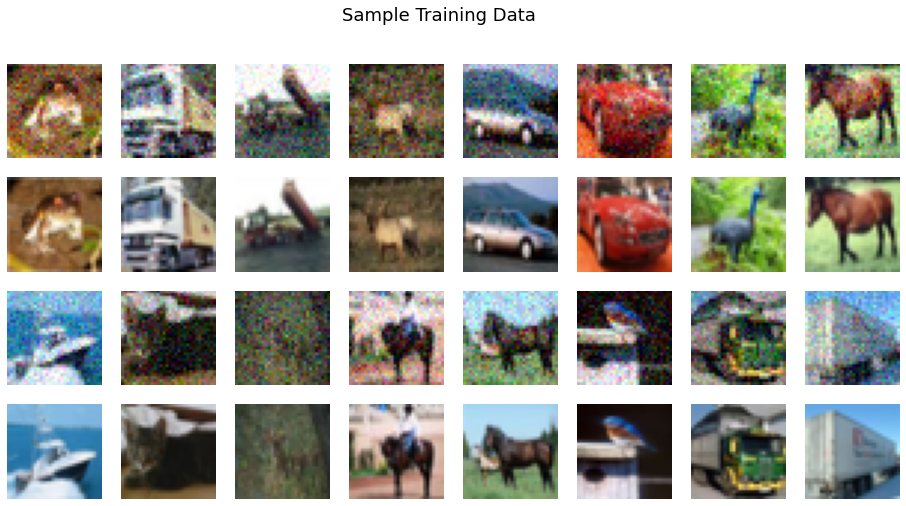

In [3]:
# Visualize few training images with their noisy images

rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)
plt.show()

In [7]:
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU

# Encoder 
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32, 32, 32)  128         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 32)  0           ['batch_normalization_6[0][

In [8]:
# Training
epochs = 25
batch_size = 256

history = autoencoder.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test)
               )

Epoch 1/25
196/196 [==============================] - 19s 48ms/step - loss: 0.5790 - val_loss: 0.6184
Epoch 2/25
196/196 [==============================] - 9s 44ms/step - loss: 0.5623 - val_loss: 0.5772
Epoch 3/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5604 - val_loss: 0.5625
Epoch 4/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5594 - val_loss: 0.5591
Epoch 5/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5587 - val_loss: 0.5564
Epoch 6/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5582 - val_loss: 0.5569
Epoch 7/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5579 - val_loss: 0.5565
Epoch 8/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5578 - val_loss: 0.5562
Epoch 9/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5575 - val_loss: 0.5561
Epoch 10/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5574 - val_l

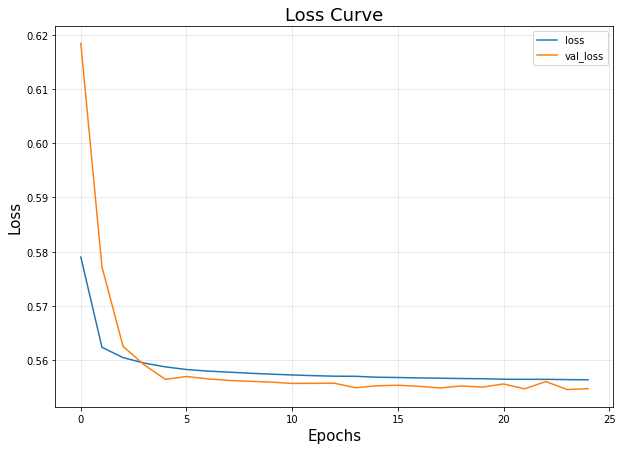

In [9]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [10]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, cifar_test_noise.shape[0]-48) 

cifar_test_images = cifar_test_noise[rand:rand+num_imgs] # slicing
cifar_test_desoided = autoencoder.predict(cifar_test_images) # predict

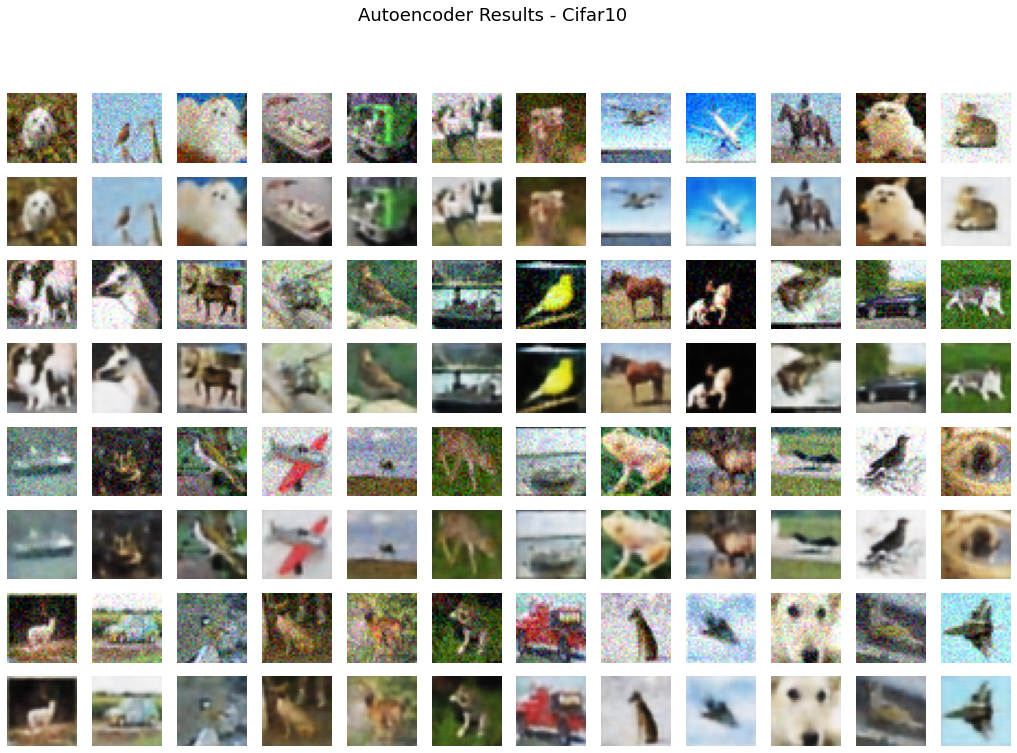

In [11]:
# Visualize test images with their denoised images

rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_desoided[i*cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)

plt.show()